# Ovrlpy applied to vizgen receptor data map

- comparing virtual horizontal slices for quality control; 
- using UMAPs to visualize clustering behavior of spatial doublets;


#### Imports:

In [1]:
%load_ext autoreload
%autoreload 2

#### Parameter definition:

In [2]:
import os
# from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.neighbors import NearestNeighbors
import anndata
import time

perf = time.perf_counter()
perf_ = perf

print(time.perf_counter()-perf)


0.00016333907842636108


In [3]:
n_slice = 2

coordinate_path = f'/dh-projects/ag-ishaque/raw_data/vizgen-merfish/vz-receptor-showcase/Slice{n_slice}/Replicate1/detected_transcripts_S{n_slice}R1.csv'
# analysis/tiesmeys/data/vizgen-merfish/vz-receptor-showcase/Slice1/Replicate1/detected_transcripts_S1R1.csv'

scale=1 # scaling factor for images/coordinats. We want to end up with cell diameter ~30px (cellpose default)
# model_type='cyto2' # cellpose model name. ['dapi','cyto','cyto2']

In [4]:

# {0:'xenium_mouse_brain',1:'merfish_mouse_brain',2:'merfish_liver'}
dataset =0

file_root = '/dh-projects/ag-ishaque/analysis/tiesmeys/spot-data-z-axis-incoherence/src'


           global_x      global_y      global_z
count  4.874067e+07  4.874067e+07  4.874067e+07
mean   4.974135e+03  3.696136e+03  2.847259e+00
std    2.237596e+03  1.731014e+03  1.945633e+00
min    5.302726e+01 -7.666222e+01  0.000000e+00
25%    3.236294e+03  2.256036e+03  1.000000e+00
50%    4.957519e+03  3.637856e+03  3.000000e+00
75%    6.799679e+03  5.120410e+03  4.000000e+00
max    9.692914e+03  7.453246e+03  6.000000e+00
n_transcripts: 48574461, panel_size: 483


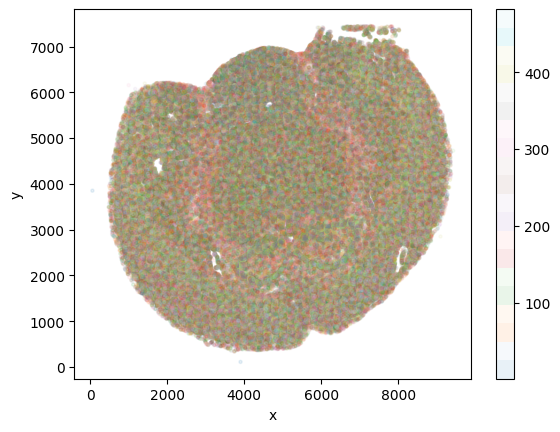

In [5]:
# Load coordinate_path data frame, read only the columns
# global_x, global_y, global_z, fov	gene:

import time

df = pd.read_csv(coordinate_path, sep=',', usecols=[2,3,4,8], header=0)[::1]

print(df.describe())


df.columns=['x','y','z','gene']
df = df[~df.gene.str.contains('Blank')]
# df.x-=df.x.min()
# df.y-=df.y.min()
# df.x/=um_per_pixel/scale
# df.y/=um_per_pixel/scale
# df.z/=um_per_pixel/scale

# df.gene.replace({'Acte1':'Gm498'})

df.gene = df.gene.astype('category')
gene_counts = df.gene.value_counts()
genes = list(gene_counts.index)

df[::200].plot.scatter(x='x',y='y',s=5,c=df[::200].gene.cat.codes,cmap='tab20',alpha=0.1)

print(f"n_transcripts: {len(df)}, panel_size: {len(genes)}")

In [6]:
signatures_ = pd.read_csv('/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/scRNAseq/trimmed_means.csv',index_col=0)

signatures_ = signatures_.T.groupby(lambda x: x.split('_')[1].split(' ')[0].split('-')[0]).apply(lambda x: x.mean(0)).T

signatures = pd.DataFrame(index=genes,columns=signatures_.columns)
signatures = signatures.fillna(0.0)

for gene in genes:
    if gene in signatures_.index:
        signatures.loc[gene] = signatures_.loc[gene]

del signatures_ 
signatures.columns=signatures.columns.str.replace('/','-')


/tmp/ipykernel_2588843/2048503760.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  signatures = signatures.fillna(0.0)


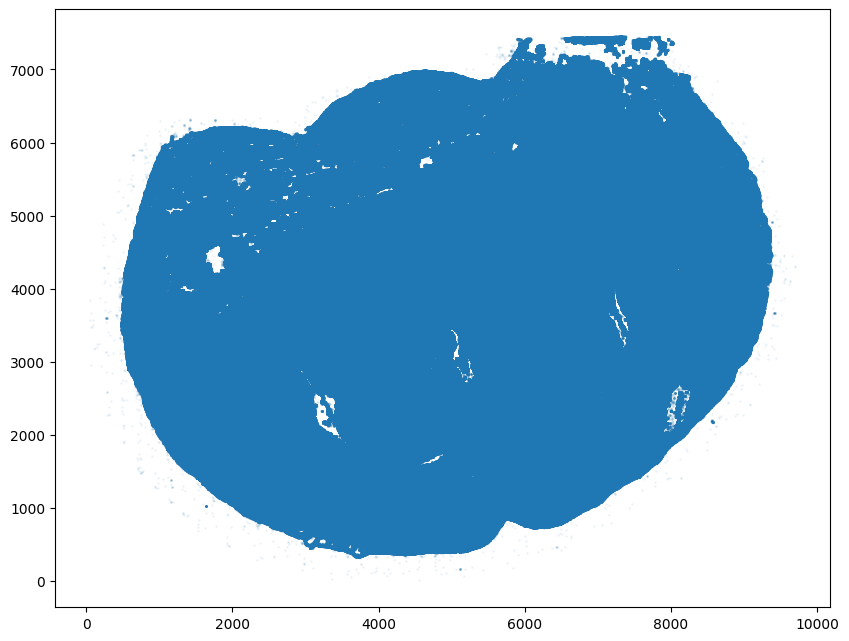

In [7]:
#
plt.figure(figsize=(10,10))


x_lims = [0,10000]
y_lims = [0,10000]

df_mask = (df.x>x_lims[0]) & (df.x<x_lims[1]) & (df.y>y_lims[0]) & (df.y<y_lims[1])

df = df[df_mask].copy()

mins = df[['x','y']].min()

# df.x-=df.x.min()
# df.y-=df.y.min()

plt.scatter(df.x,df.y,s=1,alpha=0.05)
plt.gca().set_aspect('equal') 
df.gene = df.gene.astype('str').astype('category')
gene_counts = df.gene.value_counts()
genes = gene_counts.index

# Adhere to project's global naming convention:
coordinate_df = df.copy()
del df


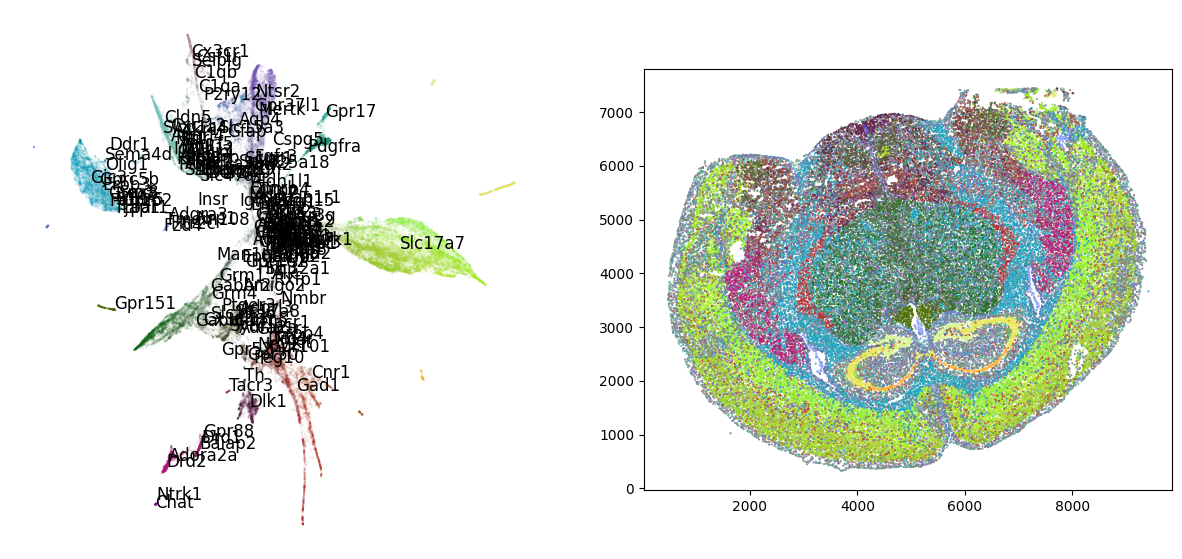

In [8]:
import ovrlpy

visualizer = ovrlpy.load_visualizer('./publication/vizgen-receptor/vizgen-receptor.vis')

signal_integrity,signal_strength = visualizer.integrity_map,visualizer.signal_map

visualizer.plot_fit()

/tmp/ipykernel_2588843/1398008384.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  signatures = signatures.fillna(0.0)


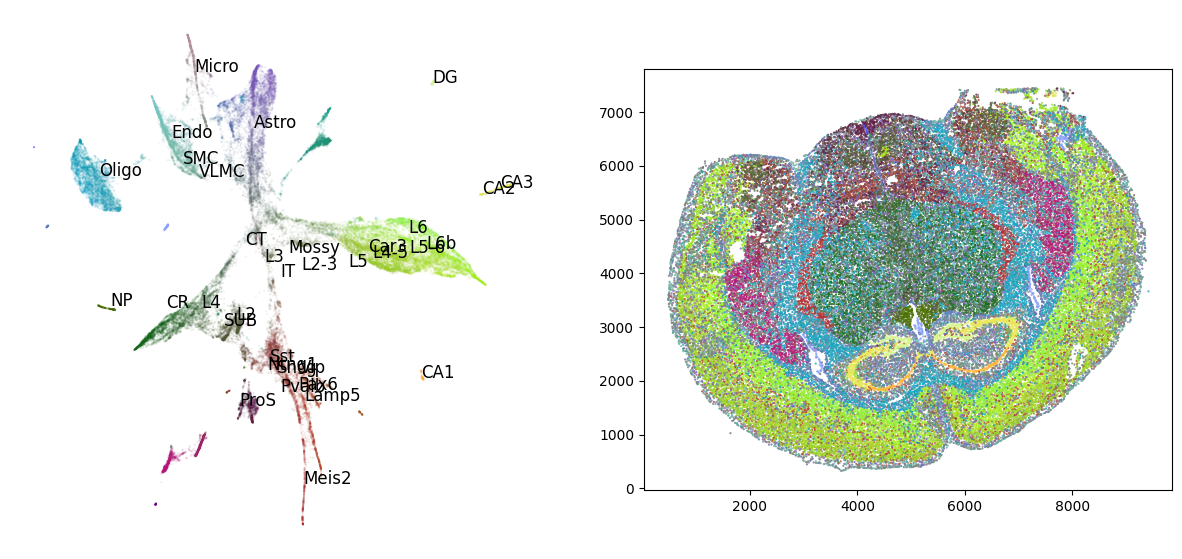

In [9]:
import numpy as np
import matplotlib.pyplot as plt

signatures_ = pd.read_csv('/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/scRNAseq/trimmed_means.csv',index_col=0)

signatures_ = signatures_.T.groupby(lambda x: x.split('_')[1].split(' ')[0].split('-')[0]).apply(lambda x: x.mean(0)).T

signatures = pd.DataFrame(index=visualizer.genes,columns=signatures_.columns)
signatures = signatures.fillna(0.0)

for gene in visualizer.genes:
    if gene in signatures_.index:
        signatures.loc[gene] = signatures_.loc[gene]

del signatures_ 

signatures.columns=signatures.columns.str.replace('/','-')

visualizer.fit_signatures(signatures)

visualizer.plot_fit()

plt.savefig("./publication/vizgen-receptor/figures/receptor-fit",dpi=300)

### Rasterize segmentation data to create a sampling mask: 

In [11]:
import h5py as h5
from shapely.geometry import Polygon
import rasterio
from rasterio.features import rasterize
import tqdm


polygons = []

max_x = 0
max_y = 0

cell_id = 0

files = os.listdir(f'/dh-projects/ag-ishaque/raw_data/vizgen-merfish/vz-receptor-showcase/Slice{n_slice}/Replicate1/cell_boundaries/')

for file in tqdm.tqdm(files,total = len(files)):
    with h5.File(f'/dh-projects/ag-ishaque/raw_data/vizgen-merfish/vz-receptor-showcase/Slice{n_slice}/Replicate1/cell_boundaries/{file}','r') as f:
        
        for i, features in enumerate (f['featuredata'].keys()):
            for j,idx_key in enumerate(f['featuredata'][features].keys()):
                
                if (isinstance(f['featuredata'][features][idx_key],h5.Dataset)):
                    # print(f['featuredata'][features][idx_key])
                    continue
                    # plt.plot(*f['featuredata'][features][idx_key]['coordinates'][0].T)

                else:
                    for m,p in enumerate(f['featuredata'][features][idx_key].keys()):                        
                        
                        polygon = Polygon(f['featuredata'][features][idx_key][p]['coordinates'][0])
                        polygons.append((polygon, cell_id))  
                        
                        max_x = max(max_x,f['featuredata'][features][idx_key][p]['coordinates'][0][:,0].max())
                        max_y = max(max_y,f['featuredata'][features][idx_key][p]['coordinates'][0][:,1].max())
                        
                        # plt.plot(*f['featuredata'][features][idx_key][p]['coordinates'][0].T)
                        
            cell_id+=1
            

segmentation_map = rasterize(polygons, out_shape=signal_strength.shape, fill=np.nan, all_touched=True, dtype=float)


segmentation_map_df = pd.DataFrame(np.where(~np.isnan(segmentation_map.T)),index=['y','x']).T
segmentation_map_df['cell_id'] = segmentation_map[segmentation_map_df.x,segmentation_map_df.y].astype(int)

ovrlpy.pre_process_coordinates(coordinate_df)

coordinate_px_df = coordinate_df[['x_pixel','y_pixel','gene']].copy().rename(columns={'x_pixel':'y','y_pixel':'x'})
merged_df = pd.merge(coordinate_px_df,segmentation_map_df,how='left',on=['x','y'])
coordinate_df['cell_id'] = merged_df.cell_id.fillna(-1).astype(int).values


cell_annotation_df = merged_df[['x','y','cell_id']].groupby('cell_id').mean()
cell_annotation_df.index = cell_annotation_df.index.astype(int)
cell_annotation_df['counts'] = merged_df.groupby('cell_id').size()


del coordinate_px_df, segmentation_map_df

 ... (more hidden) ...


/tmp/ipykernel_2588843/2423368488.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cell_annotation_df["above_threshold"] = signal_integrity_integration_groups.apply(lambda x: np.mean(x.signal_integrity_>0.3))


<Axes: title={'center': 'mean integrity distribution, MERFISH receptor'}, ylabel='Frequency'>

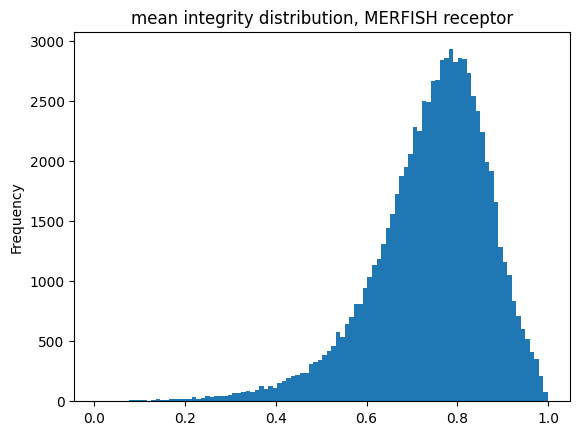

In [26]:
segmentation_map_ = segmentation_map.copy()
segmentation_map_[np.isnan(segmentation_map)]=-1
segmentation_map_ = segmentation_map_.astype(int)

signal_integrity_ = signal_integrity.copy()
signal_integrity_[signal_strength<1]=np.nan

signal_integrity_integration_mask = (signal_strength>1.5) & (segmentation_map_>=0)

signal_integrity_integration_df = pd.DataFrame(signal_integrity_[signal_integrity_integration_mask].flatten(),columns=['signal_integrity_'])
signal_integrity_integration_df['segmentation_map'] = segmentation_map_[signal_integrity_integration_mask].flatten().astype(int)

signal_integrity_integration_groups = signal_integrity_integration_df.groupby('segmentation_map')

cell_annotation_df["mean_integrity"] = signal_integrity_integration_groups.mean().signal_integrity_
cell_annotation_df["min_integrity"] = signal_integrity_integration_groups.min().signal_integrity_
cell_annotation_df["median_integrity"] = signal_integrity_integration_groups.median().signal_integrity_
cell_annotation_df["quartile_integrity"] = signal_integrity_integration_groups.quantile(0.75).signal_integrity_
cell_annotation_df["above_threshold"] = signal_integrity_integration_groups.apply(lambda x: np.mean(x.signal_integrity_>0.3))
cell_annotation_df["area"] = signal_integrity_integration_groups.size()


cell_annotation_df.mean_integrity.plot.hist(bins=100,title='mean integrity distribution, MERFISH receptor')

# plt.scatter(cell_annotation_df.x,cell_annotation_df.y,s=1,c=cell_annotation_df.min_integrity,cmap='viridis')

/tmp/ipykernel_2588843/2914987234.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bottom_count_mtx = pd.DataFrame(index=coordinate_df.gene.cat.categories,columns=cell_ids).fillna(0)
/tmp/ipykernel_2588843/2914987234.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  top_count_mtx = pd.DataFrame(index=coordinate_df.gene.cat.categories,columns=cell_ids).fillna(0)
/tmp/ipykernel_2588843/2914987234.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cur

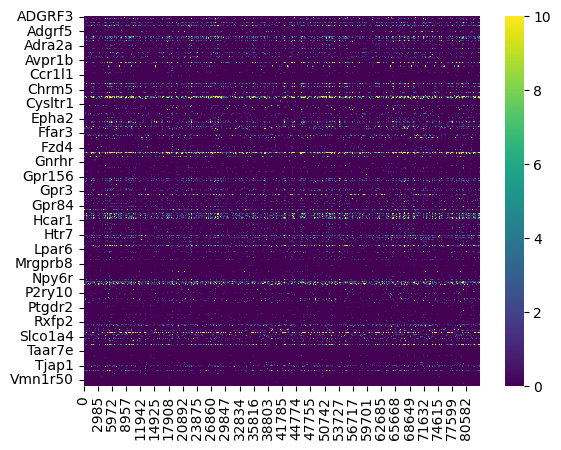

In [33]:
import seaborn as sns 

cell_ids = sorted(coordinate_df[(coordinate_df.cell_id>-1).values].cell_id.unique().astype(int))

bottom_count_mtx = pd.DataFrame(index=coordinate_df.gene.cat.categories,columns=cell_ids).fillna(0)
top_count_mtx = pd.DataFrame(index=coordinate_df.gene.cat.categories,columns=cell_ids).fillna(0)


bottom_counts = coordinate_df[(coordinate_df.z<coordinate_df.z_delim)&(coordinate_df.cell_id>-1).values].groupby("gene").apply(lambda x:x.cell_id.value_counts())
top_counts = coordinate_df[(coordinate_df.z>coordinate_df.z_delim)&(coordinate_df.cell_id>-1).values].groupby("gene").apply(lambda x:x.cell_id.value_counts())

bottom_counts_dict = bottom_counts.to_dict()
top_counts_dict = top_counts.to_dict()

for (gene, cell_id), count in tqdm.tqdm(bottom_counts_dict.items(), total=len(bottom_counts_dict)):
    bottom_count_mtx.at[gene, cell_id] = count
for (gene, cell_id), count in tqdm.tqdm(top_counts_dict.items(), total=len(top_counts_dict)):
    top_count_mtx.at[gene, cell_id] = count

# # Fill matrices using the dictionaries
# for g in tqdm.tqdm(coordinate_df.gene.cat.categories, total=len(coordinate_df.gene.cat.categories)):
#     if g in bottom_counts_dict:
#         for cell_id, count in bottom_counts_dict[g].items():
#             bottom_count_mtx.at[g, cell_id] = count
#     if g in top_counts_dict:
#         for cell_id, count in top_counts_dict[g].items():
#             top_count_mtx.at[g, cell_id] = count

# for i,g in tqdm.tqdm(enumerate(coordinate_df.gene.cat.categories),total=len(coordinate_df.gene.cat.categories)):
#     # print(bottom_counts.loc[c])
#     bottom_count_mtx.at[g] = bottom_counts[g]
#     top_count_mtx.at[g] = top_counts[g]
    
bottom_count_mtx.fillna(0,inplace=True)
top_count_mtx.fillna(0,inplace=True)
    
sns.heatmap(top_count_mtx,cmap='viridis',vmax=10)

import anndata
adata_bottom_count_mtx = anndata.AnnData(bottom_count_mtx.T)
adata_top_count_mtx = anndata.AnnData(top_count_mtx.T)

adata_bottom_count_mtx.write_h5ad("./publication/vizgen-receptor/top-bottom-qc/mapmycells/bottom_count_mtx_receptor.h5ad")
adata_top_count_mtx.write_h5ad("./publication/vizgen-receptor/top-bottom-qc/mapmycells/top_count_mtx_receptor.h5ad")

In [34]:
import os


def load_mapmycells_csv(region='whole'):
    files = os.listdir(f"publication/vizgen-receptor/top-bottom-qc/mapmycells/{region}/")
    csv = sorted([f for f in files if f.endswith(".csv") and "_r2_" in f])[-1]
    
    mapmycells_df = pd.read_csv(f"publication/vizgen-receptor/top-bottom-qc/mapmycells/{region}/{csv}",index_col=0,skiprows=4)
    
    return mapmycells_df

(6.0, 0.0)

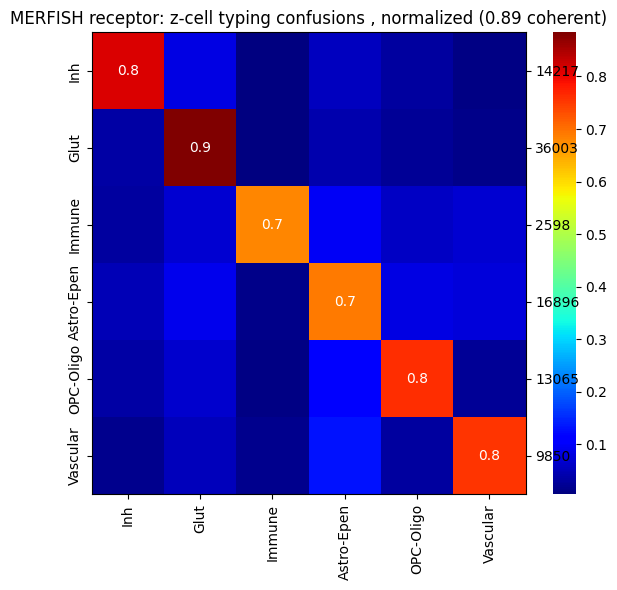

In [35]:
import seaborn as sns

# Correlation:
mapmycells_df_bottom = load_mapmycells_csv('bottom')
mapmycells_df_top = load_mapmycells_csv('top')


mapmycells_df_top['family_name'] = mapmycells_df_top.class_name.str.split(' ').str[-1]#.astype('category')
mapmycells_df_bottom['family_name'] = mapmycells_df_bottom.class_name.str.split(' ').str[-1]#.astype('category')
# all_classes = sorted(list(set(mapmycells_df_top['family_name'].unique()).union(set(mapmycells_df_bottom['family_name'].unique()))))
all_classes = 'Inh','Glut','Immune','Astro-Epen','OPC-Oligo','Vascular'
inh_classes = 'GABA','Sero'#,'Dopa'
mapmycells_df_bottom.loc[mapmycells_df_bottom['family_name'].isin(inh_classes),'family_name'] = 'Inh'
mapmycells_df_top.loc[mapmycells_df_top['family_name'].isin(inh_classes),'family_name'] = 'Inh'

global_prediction_coherence =(mapmycells_df_top.family_name.astype(str)==mapmycells_df_bottom.family_name.astype(str)).mean()

(mapmycells_df_top == mapmycells_df_bottom).mean()

celltype_confusions = pd.DataFrame(index=all_classes,columns=all_classes).astype(float)
celltype_crossconfusions = celltype_confusions.copy()

counts = pd.Series(index=all_classes,dtype=int)
annotations = pd.DataFrame(index=all_classes,columns=all_classes).astype(str)
annotations[:] = ''

for i in celltype_confusions.index:
    for j in celltype_confusions.columns:
        celltype_confusions.loc[i,j] = (((mapmycells_df_top['family_name']==i)&(mapmycells_df_bottom['family_name']==j))).sum()
        if i==j:
            celltype_crossconfusions.loc[i,j]=np.nan
            continue
        celltype_crossconfusions.loc[i,j] = celltype_confusions.loc[i,j]
        
    counts[i] = ((mapmycells_df_top['family_name']==i)|(mapmycells_df_bottom['family_name']==i)).sum()

celltype_confusions = celltype_confusions+celltype_confusions.T
celltype_confusions /= np.eye(len(celltype_confusions))+1
# celltype_confusions.index = celltype_confusions.index.str.split(' ').str[1:].str.join(' ')
# celltype_confusions.columns = celltype_confusions.columns.str.split(' ').str[1:].str.join(' ')

celltype_confusions/=celltype_confusions.sum(1)
celltype_confusions = celltype_confusions.T

celltype_crossconfusions = celltype_crossconfusions+celltype_crossconfusions.T
celltype_crossconfusions.index = celltype_crossconfusions.index.str.split(' ').str[1:].str.join(' ')
celltype_crossconfusions.columns = celltype_crossconfusions.columns.str.split(' ').str[1:].str.join(' ')

celltype_crossconfusions/=celltype_crossconfusions.sum(1)
celltype_crossconfusions = celltype_crossconfusions.T

for i in range(len(celltype_confusions.index)):
    annotations.iloc[i,i] = f"{celltype_confusions.iloc[i,i]:.1f}"        
    
fig = plt.figure(figsize=(7,6))
ax = plt.subplot(111)
sns.heatmap(celltype_confusions,annot=annotations,ax=ax,cmap='jet',fmt='')
plt.title(f"MERFISH receptor: z-cell typing confusions , normalized ({global_prediction_coherence:.2f} coherent)")

# Set the secondary y-axis ticks and labels
ax2 = ax.twinx()
ax2.set_yticks(ax.get_yticks())
ax2.set_yticklabels(counts.astype(int).astype(str))
ax2.set_ylim(ax.get_ylim())

# ax = plt.subplot(122)
# sns.heatmap(celltype_crossconfusions,ax=ax,cmap='jet')
# plt.title('vertical cell typing cross-confusion matrix, normalized')


# # Set the secondary y-axis ticks and labels
# ax2 = ax.twinx()
# ax2.set_yticks(ax.get_yticks())
# ax2.set_yticklabels(counts.astype(int).astype(str))
# ax2.set_ylim(ax.get_ylim())



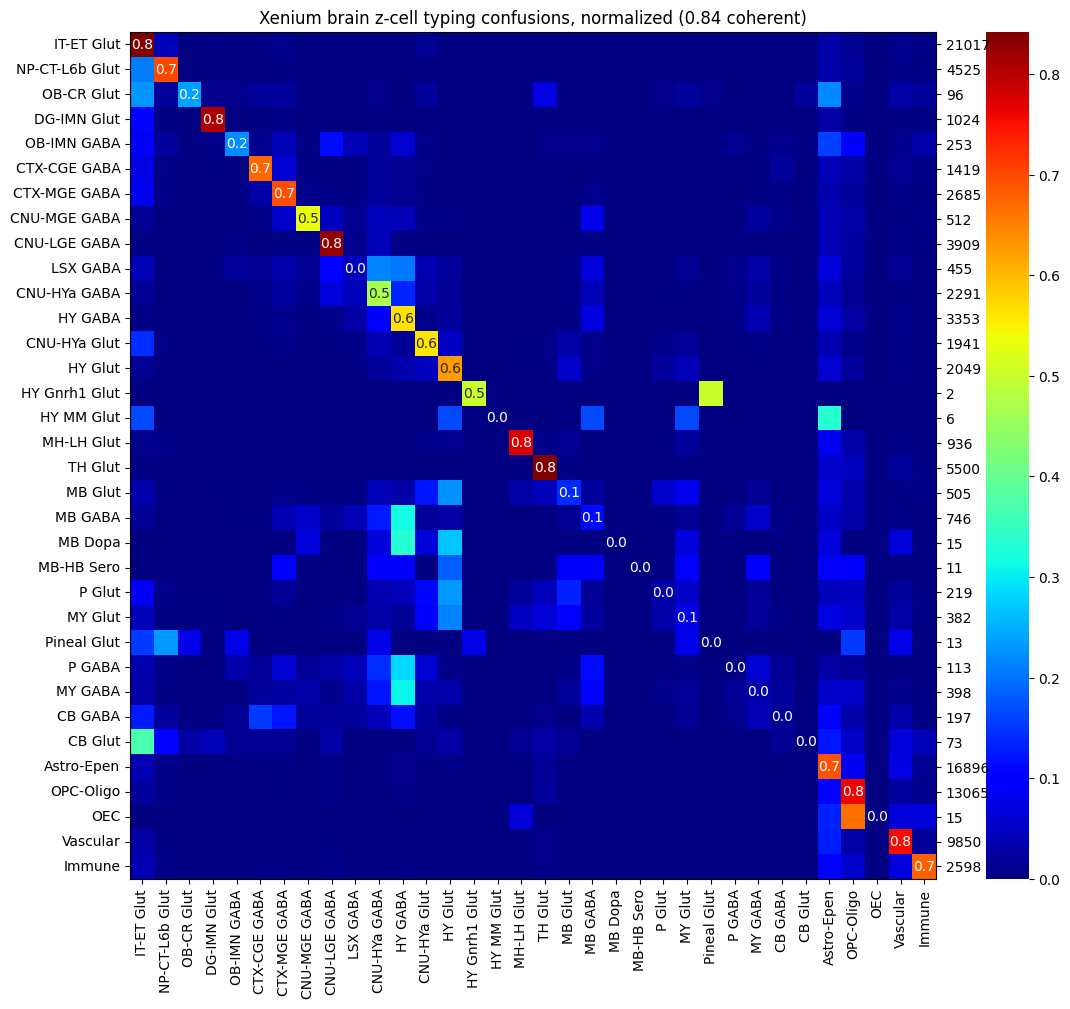

In [36]:
import seaborn as sns

# Correlation:
mapmycells_df_bottom = load_mapmycells_csv('bottom')
mapmycells_df_top = load_mapmycells_csv('top')

# ratio of coherently predicted cell types across the vertical demarcation:
global_prediction_coherence =(mapmycells_df_top.class_name.astype(str)==mapmycells_df_bottom.class_name.astype(str)).mean()

mapmycells_df_top['family_name'] = mapmycells_df_top.class_name.str.split(' ').str[-1].astype('category')
mapmycells_df_bottom['family_name'] = mapmycells_df_bottom.class_name.str.split(' ').str[-1].astype('category')
all_classes = sorted(list(set(mapmycells_df_top['class_name'].unique()).union(set(mapmycells_df_bottom['class_name'].unique()))))

(mapmycells_df_top == mapmycells_df_bottom).mean()

celltype_confusions = pd.DataFrame(index=all_classes,columns=all_classes).astype(float)
celltype_crossconfusions = celltype_confusions.copy()

counts = pd.Series(index=all_classes,dtype=int)
annotations = pd.DataFrame(index=all_classes,columns=all_classes).astype(str)
annotations[:] = ''

for i in celltype_confusions.index:
    for j in celltype_confusions.columns:
        celltype_confusions.loc[i,j] = ((mapmycells_df_top['class_name']==i)&(mapmycells_df_bottom['class_name']==j)).sum()
        if i==j:
            celltype_crossconfusions.loc[i,j]=np.nan
            continue
        celltype_crossconfusions.loc[i,j] = celltype_confusions.loc[i,j]
        
    counts[i] = ((mapmycells_df_top['class_name']==i)|(mapmycells_df_bottom['class_name']==i)).sum()


celltype_confusions = celltype_confusions+celltype_confusions.T
celltype_confusions /= np.eye(len(celltype_confusions))+1
celltype_confusions.index = celltype_confusions.index.str.split(' ').str[1:].str.join(' ')
celltype_confusions.columns = celltype_confusions.columns.str.split(' ').str[1:].str.join(' ')

celltype_confusions/=celltype_confusions.sum(1)
celltype_confusions = celltype_confusions.T


celltype_crossconfusions = celltype_crossconfusions+celltype_crossconfusions.T
celltype_crossconfusions.index = celltype_crossconfusions.index.str.split(' ').str[1:].str.join(' ')
celltype_crossconfusions.columns = celltype_crossconfusions.columns.str.split(' ').str[1:].str.join(' ')

celltype_crossconfusions/=celltype_crossconfusions.sum(1)
celltype_crossconfusions = celltype_crossconfusions.T

for i in range(len(celltype_confusions.index)):
    annotations.iloc[i,i] = f"{celltype_confusions.iloc[i,i]:.1f}"        
    
fig = plt.figure(figsize=(13,11))
ax = plt.subplot(111)
sns.heatmap(celltype_confusions,annot=annotations,ax=ax,cmap='jet',fmt='')
plt.title(f"Xenium brain z-cell typing confusions, normalized ({global_prediction_coherence:.2f} coherent)")

# Set the secondary y-axis ticks and labels
ax2 = ax.twinx()
ax2.set_yticks(ax.get_yticks())
ax2.set_yticklabels(counts.astype(int).astype(str))
ax2.set_ylim(ax.get_ylim())

plt.savefig("publication/vizgen-receptor/top-bottom-qc/celltype_combinations.pdf",dpi=300)
plt.savefig("publication/vizgen-receptor/top-bottom-qc/celltype_combinations.svg",dpi=300)


# ax = plt.subplot(122)
# sns.heatmap(celltype_crossconfusions,ax=ax,cmap='jet')
# plt.title('vertical cell typing cross-confusion matrix, normalized')


# # Set the secondary y-axis ticks and labels
# ax2 = ax.twinx()
# ax2.set_yticks(ax.get_yticks())
# ax2.set_yticklabels(counts.astype(int).astype(str))
# ax2.set_ylim(ax.get_ylim())


ValueError: 'c' argument has 61001 elements, which is inconsistent with 'x' and 'y' with size 83449.

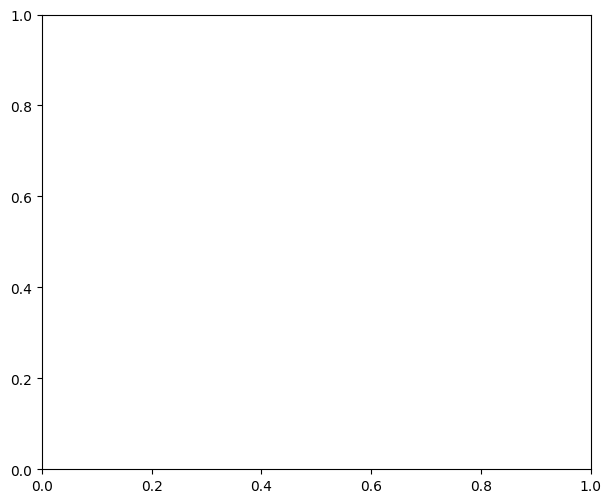

In [17]:
centimeter = 1/2.54
plt.figure(figsize=(18*centimeter,15*centimeter))


plt.scatter(cell_annotation_df.y,cell_annotation_df.x,
            c=mapmycells_df_top['family_name']==mapmycells_df_bottom['family_name'],cmap='viridis',marker='x',s=0.01,rasterized=True)

plt.gca().set_aspect('equal', adjustable='box')

plt.savefig("publication/vizgen-receptor/top-bottom-qc/doublet_map.pdf",dpi=600)
plt.savefig("publication/vizgen-receptor/top-bottom-qc/doublet_map.svg",dpi=600)

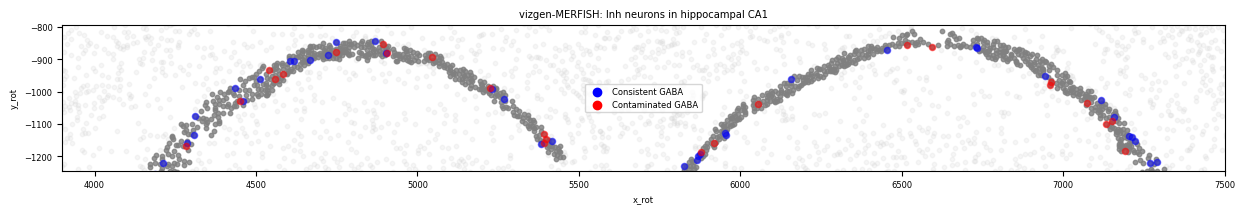

In [ ]:
# plt.figure(figsize=(20,5))

from scipy.ndimage import gaussian_filter

is_dense = (gaussian_filter((gaussian_filter(signal_strength,15)>3).astype(float),13)>0.4)[cell_annotation_df.x.astype(int),cell_annotation_df.y.astype(int)]
is_ca1 = is_dense&((cell_annotation_df.x*3-cell_annotation_df.y/1.5)<4000)

phi = 0.21-np.pi/2
rotation_matrix = np.array([[np.cos(phi),-np.sin(phi)],[np.sin(phi),np.cos(phi)]])
rotated_coords = np.dot(rotation_matrix,np.array([cell_annotation_df.x,cell_annotation_df.y])).T

cell_annotation_df['x_rot'] = rotated_coords[:,0]   
cell_annotation_df['y_rot'] = rotated_coords[:,1]


plt.figure(figsize=(15,5))
ax = plt.subplot(111)
# # plt.scatter(cell_annotation_df.x,cell_annotation_df.y, c=mapmycells_df_top.class_name==mapmycells_df_bottom.class_name,s=1,alpha=0.5,cmap="viridis")
# plt.scatter(cell_annotation_df.x,cell_annotation_df.y, c=(mapmycells_df_top.class_name.str.contains('GABA'))|(mapmycells_df_bottom.class_name.str.contains('GABA')),s=10,alpha=0.9,cmap="Blues")
# plt.scatter(cell_annotation_df.x,cell_annotation_df.y, c=(mapmycells_df_top.class_name.str.contains('GABA'))^(mapmycells_df_bottom.class_name.str.contains('GABA')),s=10,alpha=0.4,cmap="Reds",)

cell_annotation_df.plot.scatter(x='x_rot',y='y_rot',c='lightgrey',s=10,alpha=0.2,ax=ax)
cell_annotation_df[is_ca1].plot.scatter(x='x_rot',y='y_rot',c='Grey',s=10,alpha=0.8,ax=ax)
cell_annotation_df[is_ca1&((mapmycells_df_top.class_name.str.contains('GABA'))&(mapmycells_df_bottom.class_name.str.contains('GABA')))].plot.scatter(x='x_rot',y='y_rot',c='blue',s=20,alpha=0.5,ax=ax)
cell_annotation_df[is_ca1&((mapmycells_df_top.class_name.str.contains('GABA'))^(mapmycells_df_bottom.class_name.str.contains('GABA')))].plot.scatter(x='x_rot',y='y_rot',c='red',s=20,alpha=0.5,ax=ax)

ca1_inh = cell_annotation_df[is_ca1&((mapmycells_df_top.class_name.str.contains('GABA'))|(mapmycells_df_bottom.class_name.str.contains('GABA')))]
 
plt.xlim(2600*1.5,5000*1.5)
plt.ylim(-830*1.5,-530*1.5)

plt.gca().set_aspect('equal', )
plt.title('vizgen-MERFISH: Inh neurons in hippocampal CA1')

plt.legend([plt.scatter([],[],c='b'),plt.scatter([],[],c='r') ],['Consistent GABA','Contaminated GABA',],)

In [ ]:
cell_annotation_df[is_ca1&((mapmycells_df_top.class_name.str.contains('GABA'))&(mapmycells_df_bottom.class_name.str.contains('GABA')))]

,x,y,counts,mean_purity,min_purity,median_purity,quartile_purity,above_threshold,area,x_rot,y_rot
cell_id,,,,,,,,,,,
1076,2345.039581,5587.098952,859,0.819472,0.659939,0.828798,0.870173,1.000000,124.0,5953.202215,-1128.835118
1088,2349.633333,5589.066667,330,0.789766,0.510157,0.805225,0.853327,1.000000,74.0,5956.084314,-1132.917761
5843,1856.423901,4375.779030,887,0.848860,0.609401,0.859212,0.918258,1.000000,129.0,4666.637108,-903.465507
5849,1852.202425,4435.594216,1072,0.822272,0.548681,0.837903,0.896455,1.000000,168.0,4724.258201,-886.867706
5911,1818.768553,4466.265409,1590,0.795359,0.160434,0.851205,0.928479,0.979592,245.0,4747.285954,-847.774632
9447,2245.518275,6401.040205,1368,0.873300,0.543238,0.883510,0.917407,1.000000,181.0,6728.515721,-861.826092
9459,2250.501420,6405.495739,704,0.831446,0.594842,0.844551,0.919516,1.000000,97.0,6733.912157,-865.770963
12119,2378.443439,6591.714932,221,0.888437,0.718663,0.901642,0.928887,1.000000,36.0,6942.711066,-952.082978
13561,1936.156250,4145.979167,192,0.835386,0.652696,0.850132,0.872981,1.000000,32.0,4458.506735,-1029.350266


/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy_24/conda-ovrlpy/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1351: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(
/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy_24/conda-ovrlpy/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1351: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(
/dh-projects

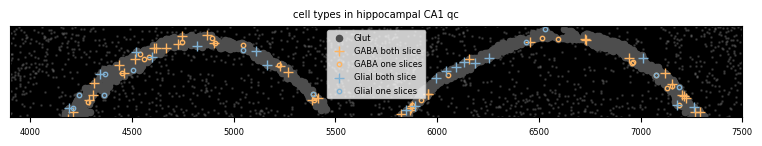

In [ ]:

plt.figure(figsize=(24*centimeter,12*centimeter),)
glial_classes = ['30 Astro-Epen', '33 Vascular', '31 OPC-Oligo', '34 Immune']

class_color_dict = {
'Dopa': (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
'Glut': (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
'Inh': (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
'Astro-Epen': (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
'Vascular': (0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
'OPC-Oligo': (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
'Immune': (1.0, 1.0, 0.7019607843137254),
'OEC': (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
}

c_glial = class_color_dict['OPC-Oligo']
c_Inh = class_color_dict['Inh']
# dense_map = gaussian_filter((gaussian_filter(signal_strength,10)>3).astype(float),13)>0.3
# is_dense = (dense_map)[adata.obs.y_rot.astype(int),adata.obs.x_rot.astype(int)]
# is_ca1 = is_dense&adata.obs.x_rot.between(1400*2,3600*2)&adata.obs.y_rot.between(2510*2,2730*2)
in_view = cell_annotation_df.x_rot.between(2600*1.5,5000*1.5)&cell_annotation_df.y_rot.between(-830*1.5,-530*1.5)

ax = plt.subplot(111,facecolor='k')

cell_annotation_df[in_view].plot.scatter(x='x_rot',y='y_rot',c='darkgrey',s=1,alpha=0.2,ax=ax,rasterized=True)
cell_annotation_df[is_ca1].plot.scatter(x='x_rot',y='y_rot',c=(0.3,0.3,0.3,),s=20,alpha=1.0,ax=ax,label="Glut",rasterized=True)
h_1 = cell_annotation_df[is_ca1&((mapmycells_df_top.class_name.str.contains('GABA'))&(mapmycells_df_bottom.class_name.str.contains('GABA')))].plot.scatter(x='x_rot',y='y_rot',marker='+',c=c_Inh,edgecolors=c_Inh,linewidth=1,s=50,ax=ax,label='GABA both slice')
h_2 = cell_annotation_df[is_ca1&((mapmycells_df_top.class_name.str.contains('GABA'))^(mapmycells_df_bottom.class_name.str.contains('GABA')))].plot.scatter(x='x_rot',y='y_rot',c=(0,0,0,0),edgecolors=c_Inh,linewidth=1,s=10,ax=ax,label='GABA one slices')

h_3 = cell_annotation_df[is_ca1&((mapmycells_df_top.class_name.isin(glial_classes)))&((mapmycells_df_bottom.class_name.isin(glial_classes)))].plot.scatter(x='x_rot',y='y_rot',marker='+',c=c_glial,edgecolors=c_glial,linewidth=1,s=50,ax=ax,label='Glial both slice')
h_4 = cell_annotation_df[is_ca1&((mapmycells_df_top.class_name.isin(glial_classes))^(mapmycells_df_bottom.class_name.isin(glial_classes)))].plot.scatter(x='x_rot',y='y_rot',c=(0,0,0,0),edgecolors=c_glial,linewidth=1,s=10,ax=ax,label='Glial one slices')

# #.plot.scatter(x='x_rot',y='y_rot',c='goldenrod',s=20,alpha=0.5,ax=ax)

# ca1_inh = adata.obs[is_ca1&((mapmycells_df_top.class_name.str.contains('GABA'))|(mapmycells_df_bottom.class_name.str.contains('GABA')))]
 
plt.xlim(2600*1.5,5000*1.5)
plt.ylim(-830*1.5,-530*1.5)

plt.gca().set_aspect('equal', )
plt.title('cell types in hippocampal CA1 qc')

# plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')  

plt.legend()#[h_1,h_2,h_3,h_4],['GABA both slices','GABA one slice','Glial both slices','Glial one slice'],)

plt.savefig("publication/vizgen-receptor/top-bottom-qc/ca1_cell_scatter.pdf",dpi=600)
plt.savefig("publication/vizgen-receptor/top-bottom-qc/ca1_cell_scatter.svg",dpi=600)

0.61 non-glut coherent


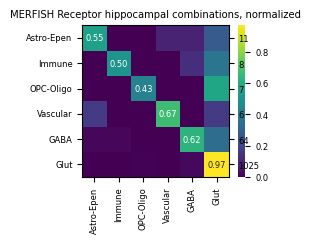

In [ ]:


ca1_df_top = mapmycells_df_top[is_ca1].copy()
ca1_df_bottom = mapmycells_df_bottom[is_ca1].copy()

ca1_df_top['family_name'] = ca1_df_top.class_name.str.split(' ').str[-1].astype('str')
ca1_df_bottom['family_name'] = ca1_df_bottom.class_name.str.split(' ').str[-1].astype('str')

all_classes = sorted(list(set(ca1_df_top['family_name'].unique()).union(set(ca1_df_bottom['family_name'].unique()))))


global_prediction_coherence =(ca1_df_top.family_name.astype(str)==ca1_df_bottom.family_name.astype(str))[~((ca1_df_top.family_name=='Glut')&(ca1_df_bottom.family_name=='Glut'))].mean()

celltype_combinations = pd.DataFrame(index=all_classes,columns=all_classes).astype(float)
celltype_crosscombinations = celltype_combinations.copy()

counts = pd.Series(index=all_classes,dtype=int)
annotations = pd.DataFrame(index=all_classes,columns=all_classes).astype(str)
annotations[:] = ''

for i in celltype_combinations.index:
    for j in celltype_combinations.columns:
        celltype_combinations.loc[i,j] = ((ca1_df_top['family_name']==i)&(ca1_df_bottom['family_name']==j)).sum()
        if i==j:
            celltype_crosscombinations.loc[i,j]=np.nan
            continue
        celltype_crosscombinations.loc[i,j] = celltype_combinations.loc[i,j]
        
    counts[i] = ((ca1_df_top['family_name']==i)|(ca1_df_bottom['family_name']==i)).sum()

celltype_combinations = celltype_combinations+celltype_combinations.T
celltype_combinations /= np.eye(len(celltype_combinations))+1

celltype_combinations[:] = celltype_combinations/celltype_combinations.sum(1)
celltype_combinations = celltype_combinations.T


celltype_crosscombinations = celltype_crosscombinations+celltype_crosscombinations.T
celltype_crosscombinations.index = celltype_crosscombinations.index.str.split(' ').str[1:].str.join(' ')
celltype_crosscombinations.columns = celltype_crosscombinations.columns.str.split(' ').str[1:].str.join(' ')

celltype_crosscombinations/=celltype_crosscombinations.sum(1)
celltype_crosscombinations = celltype_crosscombinations.T

axis_ticks = ["Astro-Epen","Immune","OPC-Oligo", "Vascular","GABA","Glut"]

for i in range(len(celltype_combinations.index)):
    annotations.iloc[i,i] = f"{celltype_combinations.iloc[i,i]:.2f}"        

    
fig = plt.figure(figsize=(6*centimeter,5*centimeter))
ax = plt.subplot(111)
sns.heatmap(celltype_combinations.loc[axis_ticks,axis_ticks],annot=annotations.loc[axis_ticks,axis_ticks],ax=ax,cmap='viridis',fmt='')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title(f"MERFISH Receptor hippocampal combinations, normalized")

# Set the secondary y-axis ticks and labels
ax2 = ax.twinx()
ax2.set_yticks(ax.get_yticks())
ax2.set_yticklabels(counts[axis_ticks].astype(int).astype(str))
ax2.set_ylim(ax.get_ylim())

plt.savefig("publication/vizgen-receptor/top-bottom-qc/ca1_inh_combinations.pdf",dpi=300)
plt.savefig("publication/vizgen-receptor/top-bottom-qc/ca1_inh_combinations.svg",dpi=300)

print(f"{global_prediction_coherence:.2f} non-glut coherent")

In [39]:
adata = anndata.AnnData(X=bottom_count_mtx.T+top_count_mtx.T,obs=cell_annotation_df)
adata.shape,mapmycells_df_top.shape,mapmycells_df_top.shape

/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy_24/conda-ovrlpy/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


((83449, 483), (83449, 14), (83449, 14))

### visualize the behavior of spatial doublets in gene expression UMAP space:

In [40]:
from sklearn.decomposition import PCA
from umap import UMAP
from ovrlpy._ovrlp import _BIH_CMAP
import random

random.seed(42)



idcs  = np.arange(0,adata.shape[0])
random.shuffle(idcs)
idcs = idcs[:(adata.obs.mean_integrity>0.7).sum()]

umap = UMAP(n_components=2,n_neighbors=20)

pca = PCA(n_components=30)

plt.figure(figsize=(15,6))

# for i in range (3):
    # ax = plt.subplot(1,3,i+1)

facs_global = pca.fit_transform(adata.X)#[adata.obs['mean_integrity']>0.7])
embedding_global = umap.fit_transform(facs_global)
c=adata.obs['mean_integrity']

facs_cleaned = pca.fit_transform(adata.X[adata.obs['mean_integrity']>0.7])
embedding_cleaned = umap.fit_transform(facs_cleaned)
# c=mapmycells_df_top['family_name'].astype('category').cat.codes[adata.obs['mean_integrity']>0.7]

facs_downsampled = pca.fit_transform(adata.X[idcs])
embedding_downsampled = umap.fit_transform(facs_downsampled)
# c=mapmycells_df_top['family_name'].astype('category').cat.codes.values[idcs]


<Figure size 1500x600 with 0 Axes>

/tmp/ipykernel_2588843/2126819148.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_clean_df[['x','y']] = embedding_cleaned


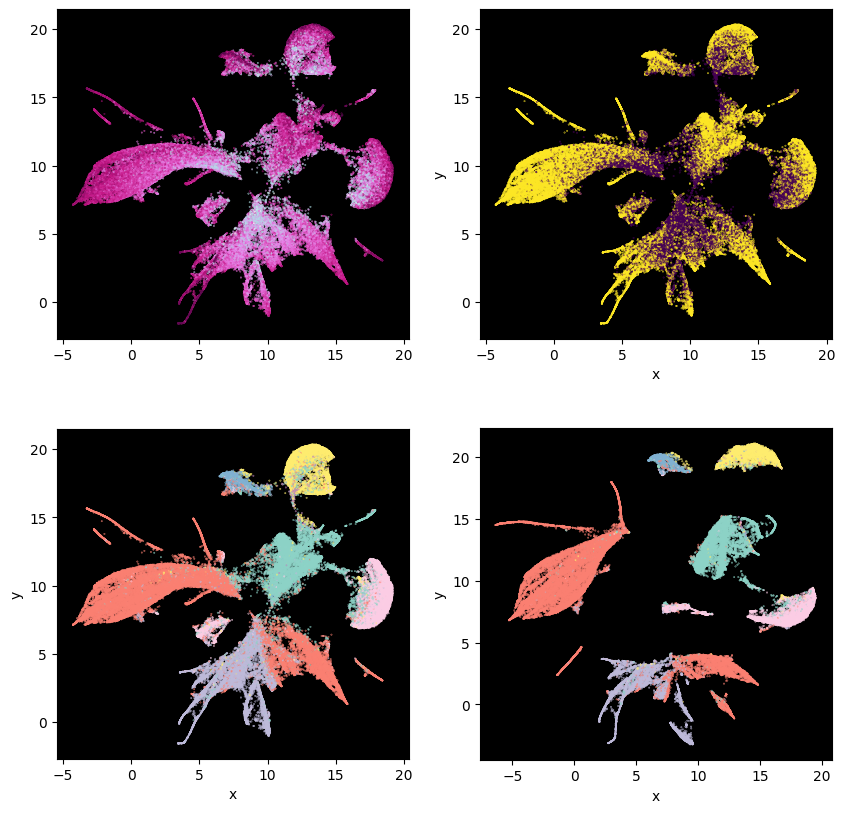

In [50]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import nipy_spectral

random.seed(42)
shuffled = np.arange(35)
random.shuffle(shuffled)
mapmycells_class_cmap = ListedColormap(nipy_spectral(shuffled/35))

plot_df = pd.DataFrame({'x':embedding_global[:,0],'y':embedding_global[:,1],'class_name':mapmycells_df_bottom['class_name'],'cluster_name':mapmycells_df_bottom['cluster_name'].astype('category'),})
 
plot_df['class_short'] = plot_df.class_name.str.split(' ').str[-1]
plot_df.loc[plot_df.cluster_name.str.contains('VLMC'),'class_short']='VLMC'
plot_df['class_short'] = plot_df['class_short'].astype('category')

plot_clean_df = plot_df.loc[(adata.obs['mean_integrity']>0.7).values]
plot_clean_df[['x','y']] = embedding_cleaned   

plt.figure(figsize=(10,10))

ax_global = plt.subplot(221,facecolor='k')
ax_global.scatter(embedding_global[:,0],embedding_global[:,1],c=adata.obs['mean_integrity'],cmap=_BIH_CMAP,s=0.1,rasterized=True)
ax_global.set_aspect('equal')

ax_threshold = plt.subplot(222,facecolor='k')
plot_df.plot.scatter('x','y',c=adata.obs['mean_integrity']>0.7,cmap='viridis',s=0.1,ax=ax_threshold,rasterized=True,colorbar=False)
ax_threshold.set_aspect('equal')

ax_celltypes = plt.subplot(223,facecolor='k')
plot_df.plot.scatter('x','y',c='class_short',cmap='Set3',s=0.1,ax=ax_celltypes,rasterized=True,colorbar=False)
ax_celltypes.set_aspect('equal')

ax_cleaned = plt.subplot(224,facecolor='k')
plot_clean_df.plot.scatter('x','y',c='class_short',cmap='Set3',s=0.1,ax=ax_cleaned,rasterized=True,colorbar=False)
ax_cleaned.set_aspect('equal')

plt.savefig("publication/vizgen-receptor/top-bottom-qc/umap_cleaning.svg",dpi=600)
